This Jupyter cell:

1. Reads the FOM values from your log file using regex pattern matching
1. Organizes the data into a structured format
3. Creates 2D heatmaps for each AlN thickness value, showing how FOM varies with block width and height
4. Adds contour lines to better visualize the optimal regions
5. Creates a 3D scatter plot to visualize all data points at once
6. Identifies and highlights the best configuration

You can adjust the path to your log directory if needed. The visualization should help you identify the optimal parameter combinations for your trilayer structure.

Block widths: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
Block heights: [0.01       0.03111111 0.05222222 0.07333333 0.09444444 0.11555556
 0.13666667 0.15777778 0.17888889 0.2       ]
AlN thicknesses: [0.01   0.0575 0.105  0.1525 0.2   ]

Best configuration:
Block width: 0.050 μm
Block height: 0.010 μm
AlN thickness: 0.105 μm
FOM value: 0.3620


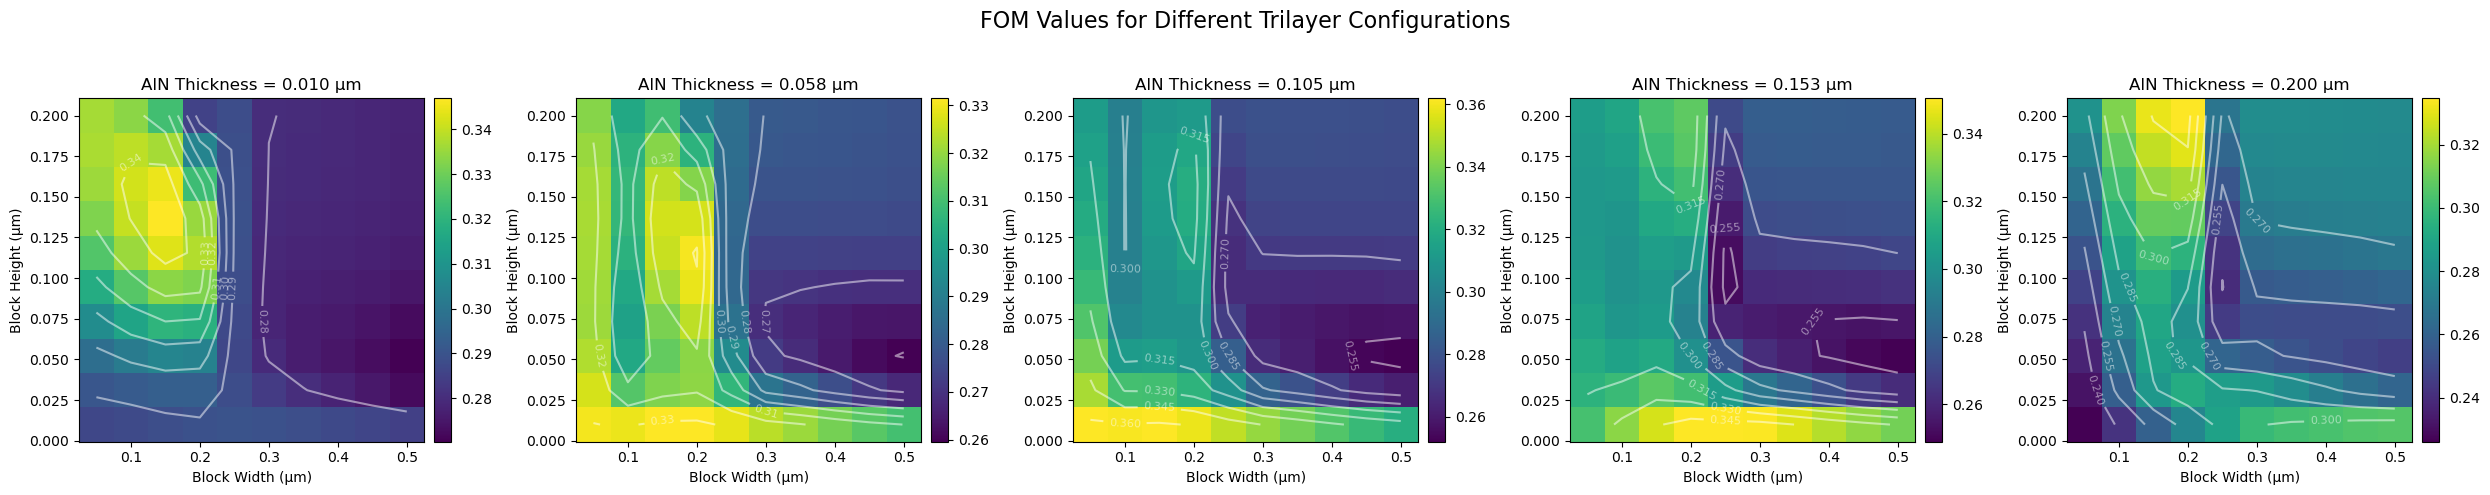

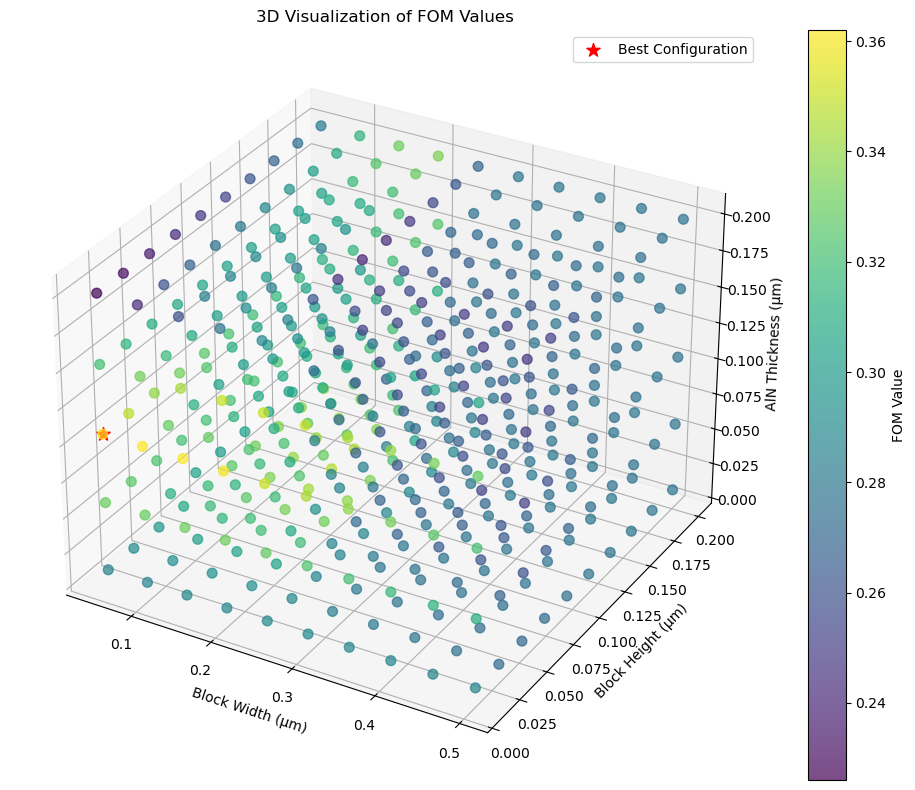

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Path to your log directory - update this to your actual log path
fom_file = os.path.join('../logs/def-eb619965_1', 'fom_values.txt')

# Read the FOM values file
with open(fom_file, 'r') as f:
    content = f.read()

# Parse the data using regex
pattern = r"block_width=([\d.]+), block_height=([\d.]+), AlN_thickness=([\d.]+)\nFOM Value: ([\d.]+)"
matches = re.findall(pattern, content)

# Convert to numeric values and organize data
data = []
for match in matches:
    block_width = float(match[0])
    block_height = float(match[1])
    aln_thickness = float(match[2])
    fom_value = float(match[3])
    data.append((block_width, block_height, aln_thickness, fom_value))

# Convert to numpy array for easier manipulation
data_array = np.array(data)

# Get unique values for each parameter
widths = np.unique(data_array[:, 0])
heights = np.unique(data_array[:, 1])
thicknesses = np.unique(data_array[:, 2])

print(f"Block widths: {widths}")
print(f"Block heights: {heights}")
print(f"AlN thicknesses: {thicknesses}")

# Create a figure with subplots for each AlN thickness
fig, axes = plt.subplots(1, len(thicknesses), figsize=(5*len(thicknesses), 5), squeeze=False)
fig.suptitle('FOM Values for Different Trilayer Configurations', fontsize=16)

# Create heatmaps for each AlN thickness
for i, thickness in enumerate(thicknesses):
    # Filter data for this thickness
    thickness_data = data_array[data_array[:, 2] == thickness]
    
    # Create a 2D grid for the heatmap
    heatmap_data = np.zeros((len(heights), len(widths)))
    
    # Fill the grid with FOM values
    for row in thickness_data:
        w_idx = np.where(widths == row[0])[0][0]
        h_idx = np.where(heights == row[1])[0][0]
        heatmap_data[h_idx, w_idx] = row[3]
    
    # Plot the heatmap
    ax = axes[0, i]
    im = ax.pcolormesh(widths, heights, heatmap_data, cmap='viridis', shading='auto')
    
    # Add contour lines
    contour = ax.contour(widths, heights, heatmap_data, colors='white', alpha=0.5)
    ax.clabel(contour, inline=True, fontsize=8)
    
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    
    # Set labels
    ax.set_xlabel('Block Width (μm)')
    ax.set_ylabel('Block Height (μm)')
    ax.set_title(f'AlN Thickness = {thickness:.3f} μm')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create a 3D scatter plot to visualize all data points
fig2 = plt.figure(figsize=(10, 8))
ax3d = fig2.add_subplot(111, projection='3d')

# Scatter plot with color representing FOM value
scatter = ax3d.scatter(data_array[:, 0], data_array[:, 1], data_array[:, 2], 
                       c=data_array[:, 3], cmap='viridis', s=50, alpha=0.7)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('FOM Value')

# Set labels
ax3d.set_xlabel('Block Width (μm)')
ax3d.set_ylabel('Block Height (μm)')
ax3d.set_zlabel('AlN Thickness (μm)')
ax3d.set_title('3D Visualization of FOM Values')

# Find the best configuration
best_idx = np.argmax(data_array[:, 3])
best_config = data_array[best_idx]
print(f"\nBest configuration:")
print(f"Block width: {best_config[0]:.3f} μm")
print(f"Block height: {best_config[1]:.3f} μm")
print(f"AlN thickness: {best_config[2]:.3f} μm")
print(f"FOM value: {best_config[3]:.4f}")

# Mark the best configuration in the 3D plot
ax3d.scatter([best_config[0]], [best_config[1]], [best_config[2]], 
             color='red', s=100, marker='*', label='Best Configuration')
ax3d.legend()

plt.tight_layout()
plt.show()


This Jupyter cell:

1. Finds all emissivity files in your log directory
2. Extracts the block height, block width, and AlN thickness parameters from the filenames
3. Creates interactive sliders to select specific parameter values
4. Plots:
    * The emissivity profile across wavelengths
    * The spectral power density (emissivity × blackbody radiation)
    * Highlights regions above and below the bandgap wavelength (1.71 μm for 0.726 eV)
5. Calculates and displays a figure of merit (ratio of power below bandgap to total power)
6. Optionally compares the selected configuration with other configurations

The interactive sliders make it easy to explore how different structural parameters affect the emissivity profile. The comparison feature helps you visually identify which configurations perform better for your TPV application.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from ipywidgets import interact, FloatSlider, fixed

# Path to your log directory - update this to your actual log path
log_dir = '../logs/def-eb619965_1'
# Find the most recent log directory (or specify a particular one)

# Get all emissivity files
emissivity_files = glob.glob(os.path.join(log_dir, 'emissivity_*.txt'))
print(f"Found {len(emissivity_files)} emissivity files")

# Extract parameters from filenames
params_list = []
for file_path in emissivity_files:
    filename = os.path.basename(file_path)
    # Parse parameters from filename: emissivity_{block_height}H_{block_width}W_{aln_thickness}AlN.txt
    parts = filename.replace('emissivity_', '').replace('.txt', '').split('_')
    
    block_height = float(parts[0].replace('H', ''))
    block_width = float(parts[1].replace('W', ''))
    aln_thickness = float(parts[2].replace('AlN', ''))
    
    params_list.append({
        'block_height': block_height,
        'block_width': block_width,
        'aln_thickness': aln_thickness,
        'file_path': file_path
    })

# Get unique values for each parameter
block_heights = sorted(list(set([p['block_height'] for p in params_list])))
block_widths = sorted(list(set([p['block_width'] for p in params_list])))
aln_thicknesses = sorted(list(set([p['aln_thickness'] for p in params_list])))

print(f"Block heights: {block_heights}")
print(f"Block widths: {block_widths}")
print(f"AlN thicknesses: {aln_thicknesses}")

# Load wavelengths from the simulation parameters
wavelengths = np.linspace(.350, 3, 2651)
wavelengths = wavelengths[(wavelengths != 0.5) & (wavelengths != 1.0)]  # Remove problematic wavelengths

# Function to find the closest value in a list
def find_closest(value, options):
    return min(options, key=lambda x: abs(x - value))

# Function to plot emissivity for given parameters
def plot_emissivity(block_height, block_width, aln_thickness, compare=False):
    # Find closest parameter values in our dataset
    h = find_closest(block_height, block_heights)
    w = find_closest(block_width, block_widths)
    t = find_closest(aln_thickness, aln_thicknesses)
    
    # Find the matching file
    matching_params = [p for p in params_list 
                      if abs(p['block_height'] - h) < 1e-5 
                      and abs(p['block_width'] - w) < 1e-5 
                      and abs(p['aln_thickness'] - t) < 1e-5]
    
    if not matching_params:
        print(f"No data found for parameters close to: height={h}, width={w}, thickness={t}")
        return
    
    file_path = matching_params[0]['file_path']
    emissivity = np.loadtxt(file_path)
    
    plt.figure(figsize=(12, 6))
    
    # Plot emissivity vs wavelength
    plt.subplot(1, 2, 1)
    plt.plot(wavelengths, emissivity, 'b-', linewidth=2)
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Emissivity')
    plt.title(f'Emissivity Profile\nH={h:.3f}μm, W={w:.3f}μm, AlN={t:.3f}μm')
    plt.grid(True, alpha=0.3)
    
    # Add vertical line at bandgap wavelength (0.726 eV = ~1.71 μm)
    bandgap_wl = 1.71
    plt.axvline(x=bandgap_wl, color='r', linestyle='--', label='Bandgap (0.726 eV)')
    
    # Highlight regions (below and above bandgap)
    plt.axvspan(wavelengths[0], bandgap_wl, alpha=0.2, color='green', label='Desired emission')
    plt.axvspan(bandgap_wl, wavelengths[-1], alpha=0.2, color='red', label='Undesired emission')
    plt.legend()
    
    # Plot spectral power density (emissivity * blackbody)
    plt.subplot(1, 2, 2)
    
    # Calculate blackbody radiation at T_e = 2073.15K (from your code)
    h = 6.626070e-34  # Js Planck's constant
    c = 2.997925e8    # m/s speed of light
    k_B = 1.380649e-23  # J/K Boltzmann constant
    T_e = 2073.15     # K emitter temperature
    
    # Convert wavelengths to meters for calculation
    wl_m = wavelengths * 1e-6
    
    # Calculate spectral radiance (W/m²/m)
    bb_spectral = (2*h*c**2) / ((np.exp((h*c)/(k_B*T_e*wl_m))-1) * wl_m**5)
    
    # Multiply by emissivity to get spectral power density
    spectral_power = emissivity * bb_spectral
    
    # Normalize for better visualization
    spectral_power = spectral_power / np.max(spectral_power)
    
    plt.plot(wavelengths, spectral_power, 'g-', linewidth=2)
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Normalized Spectral Power')
    plt.title('Spectral Power Density (Emissivity × Blackbody)')
    plt.grid(True, alpha=0.3)
    
    # Add vertical line at bandgap wavelength
    plt.axvline(x=bandgap_wl, color='r', linestyle='--', label='Bandgap (0.726 eV)')
    
    # Highlight regions
    plt.axvspan(wavelengths[0], bandgap_wl, alpha=0.2, color='green', label='Useful power')
    plt.axvspan(bandgap_wl, wavelengths[-1], alpha=0.2, color='red', label='Wasted power')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display FOM
    # This is the accurate version of the power_ratio function
    import sys
    sys.path.append('../trials')
    import ff
    import torch
    fom = ff.power_ratio(torch.tensor(wavelengths), torch.tensor(emissivity), ff.T_e, .726)
    
    print(f"Figure of Merit (power below bandgap / total power): {fom:.4f}")
    
    if compare:
        # Compare with other configurations
        plt.figure(figsize=(12, 6))
        
        # Plot the current configuration
        plt.plot(wavelengths, emissivity, 'b-', linewidth=2, 
                 label=f'H={h:.3f}μm, W={w:.3f}μm, AlN={t:.3f}μm')
        
        # Plot a few other configurations for comparison
        colors = ['r', 'g', 'm', 'c', 'y']
        color_idx = 0
        
        # Get some different configurations to compare
        other_params = [p for p in params_list 
                       if not (abs(p['block_height'] - h) < 1e-5 
                              and abs(p['block_width'] - w) < 1e-5 
                              and abs(p['aln_thickness'] - t) < 1e-5)]
        
        # Select a few different configurations (max 5)
        compare_params = other_params[:5] if len(other_params) > 5 else other_params
        
        for p in compare_params:
            other_emissivity = np.loadtxt(p['file_path'])
            plt.plot(wavelengths, other_emissivity, 
                     color=colors[color_idx], linestyle='--', 
                     label=f"H={p['block_height']:.3f}μm, W={p['block_width']:.3f}μm, AlN={p['aln_thickness']:.3f}μm")
            color_idx = (color_idx + 1) % len(colors)
        
        plt.xlabel('Wavelength (μm)')
        plt.ylabel('Emissivity')
        plt.title('Comparison of Different Configurations')
        plt.axvline(x=bandgap_wl, color='k', linestyle='--', label='Bandgap (0.726 eV)')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

# Create interactive widget
interact(
    plot_emissivity,
    block_height=FloatSlider(min=min(block_heights), max=max(block_heights), 
                            step=(max(block_heights)-min(block_heights))/len(block_heights), 
                            value=block_heights[len(block_heights)//2]),
    block_width=FloatSlider(min=min(block_widths), max=max(block_widths), 
                           step=(max(block_widths)-min(block_widths))/len(block_widths), 
                           value=block_widths[len(block_widths)//2]),
    aln_thickness=FloatSlider(min=min(aln_thicknesses), max=max(aln_thicknesses), 
                             step=(max(aln_thicknesses)-min(aln_thicknesses))/len(aln_thicknesses), 
                             value=aln_thicknesses[len(aln_thicknesses)//2]),
    compare=True
);


Found 500 emissivity files
Block heights: [0.01, 0.03111111111111111, 0.052222222222222225, 0.07333333333333333, 0.09444444444444444, 0.11555555555555555, 0.1366666666666667, 0.1577777777777778, 0.1788888888888889, 0.2]
Block widths: [0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45, 0.5]
AlN thicknesses: [0.01, 0.0575, 0.105, 0.15250000000000002, 0.2]


interactive(children=(FloatSlider(value=0.11555555555555555, description='block_height', max=0.2, min=0.01, st…